# Integrate SAM2 with GroundingDINO

### Import required dependencies

In [1]:
from itertools import chain

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

### Load models

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

GROUNDING_DINO_MODEL_ID = "IDEA-Research/grounding-dino-base"
grounding_dino_processor = AutoProcessor.from_pretrained(GROUNDING_DINO_MODEL_ID)
grounding_dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(
    GROUNDING_DINO_MODEL_ID
).to(device)

sam2_model = build_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_l.yaml",
    ckpt_path="../checkpoints/sam2.1_hiera_large.pt",
    device=device,
)

### Load original image

In [3]:
image = cv2.imread("../assets/cars.jpg", cv2.IMREAD_COLOR_RGB)

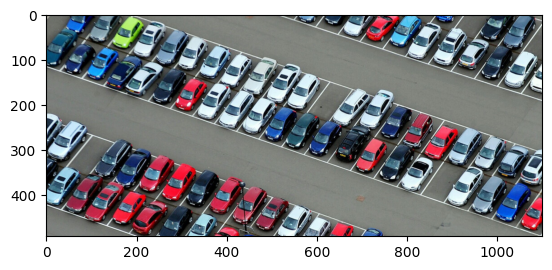

In [4]:
plt.imshow(image)
plt.show()

### Detect all cars and return bounding boxes

In [5]:
text_prompt = "car."

grounding_dino_inputs = grounding_dino_processor(
    images=image,
    text=text_prompt,
    return_tensors="pt",
).to(device)

with torch.no_grad():
    grounding_dino_outputs = grounding_dino_model(**grounding_dino_inputs)

grounding_dino_results = (
    grounding_dino_processor.post_process_grounded_object_detection(
        outputs=grounding_dino_outputs,
        input_ids=grounding_dino_inputs.input_ids,
        box_threshold=0.35,
        text_threshold=0.20,
        target_sizes=[image.shape[:-1]],
    )
)
boxes = grounding_dino_results[0]["boxes"]

### Retrieve all masks

In [6]:
sam2_predictor = SAM2ImagePredictor(sam2_model)
sam2_predictor.set_image(image)

masks, _, _ = sam2_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=boxes.cpu().numpy(),
    multimask_output=False,
)

### Merge masks

In [7]:
def merge_masks(masks_array: np.ndarray):
    def mask_generator():
        match masks_array.ndim:
            case 3:
                yield from masks_array
            case 4:
                yield from chain.from_iterable(masks_array)
            case _:
                raise ValueError(f"Unexpected masks dimension: {masks_array.ndim}")

    combined_mask = np.sum(list(mask_generator()), axis=0)
    combined_mask = (combined_mask > 0).astype(np.uint8) * 255
    return combined_mask


merged_mask = merge_masks(masks)

### Show results

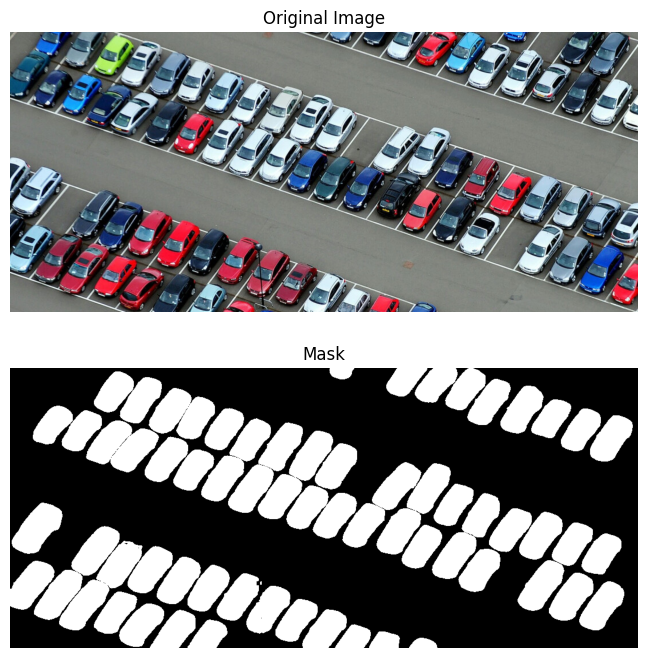

In [8]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.imshow(merged_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()